### Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import time
## models
from lightgbm import LGBMClassifier
# save model
from sklearn.externals import joblib
# model testing
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix 
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, brier_score_loss, recall_score, precision_score
from sklearn.utils.fixes import signature
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

/anaconda3/envs/aml/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Reading Test Data and Model

In [2]:
data_location = '../data/'
model_location = "../modelling/classification_models/LightGBM_Unoptimized_20191017-182530/LightGBM_Unoptimized20191017-182530.pkl"

In [3]:
# read input data
print("Reading Test Data...")
start = time.time()
X_test = pd.read_pickle(data_location + 'X_test_scaled.pkl')
y_test = pd.read_pickle(data_location + 'y_test.pkl')
print('Read Test Data!')
print('Time: ',time.time() - start)

Reading Test Data...
Read Test Data!
Time:  1.7943370342254639


In [4]:
model = joblib.load(model_location)

In [5]:
def get_predictions(model, test):
    # get predictions
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    return preds

In [6]:
preds = get_predictions(model, test = X_test.values)

In [7]:
def find_cutoff(ground_truth, predictions, metric):
    best_score = 0
    best_cutoff = 0
    for i in np.linspace(0, 1, 101):
        y_pred = (predictions>=i).astype(int)
        score = metric(y_true = ground_truth, y_pred = y_pred)
        if score >= best_score:
            best_cutoff = i
            best_score = score
    return best_cutoff

In [8]:
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)

In [9]:
y_pred = (preds>=best_cutoff).astype(int)

In [10]:
def ml_report(model, y_true, predictions, cutoff = 0.5, top_feats = 10):
    y_pred = (preds>=cutoff).astype(int)
    print("Classification report:\n%s\n"
          % classification_report(y_true, y_pred))
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 4))
    
    # print model performance
    print("F1 Score: %.2f" %f1_score(y_true, y_pred))
    print("Recall: %.2f" %recall_score(y_true, y_pred))
    print("Precision: %.2f" %precision_score(y_true, y_pred))
    print("Accuracy: %.2f" %accuracy_score(y_true, y_pred))
    print("Brier Score: %.2f" %brier_score_loss(y_true, y_pred))
    
    # confusion matrix
    plt.subplot(1, 4, 1)
    df_cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred), 
        index=[0, 1], 
        columns=[0, 1], 
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # roc curve
    plt.subplot(1, 4, 2)
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, '#e74c3c', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', color = '#34495e')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # p-r curve
    plt.subplot(1, 4, 3)
    average_precision = average_precision_score(y_true, preds)
    precision, recall, _ = precision_recall_curve(y_true, preds)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='#e74c3c', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='#e74c3c', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.4f}'.format(
              average_precision))
    plt.show()
    print("\n")
    plt.figure(figsize = (14, 10))
    # feature imp plot
    feat_imps = model.feature_importances_
    top_n_feats = np.argsort(feat_imps)[::-1][:top_feats]
    plt.title('Feature Importance')
    sns.barplot(x = feat_imps[top_n_feats], y = X_test.columns[top_n_feats])
    plt.xlabel("Importances")
    plt.ylabel("Features")
    
    plt.show()

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5819
           1       0.80      0.78      0.79       544

   micro avg       0.96      0.96      0.96      6363
   macro avg       0.89      0.88      0.88      6363
weighted avg       0.96      0.96      0.96      6363


F1 Score: 0.79
Recall: 0.78
Precision: 0.80
Accuracy: 0.96
Brier Score: 0.04


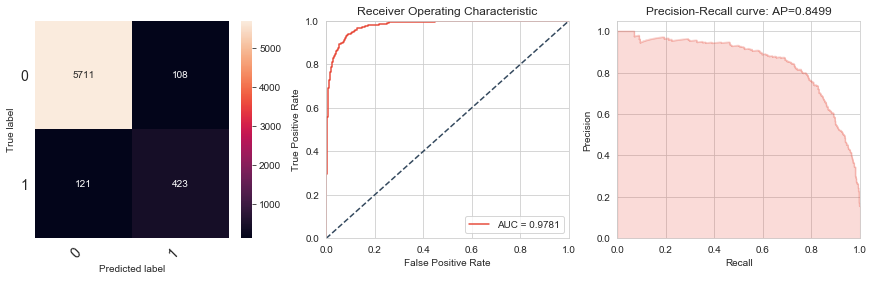

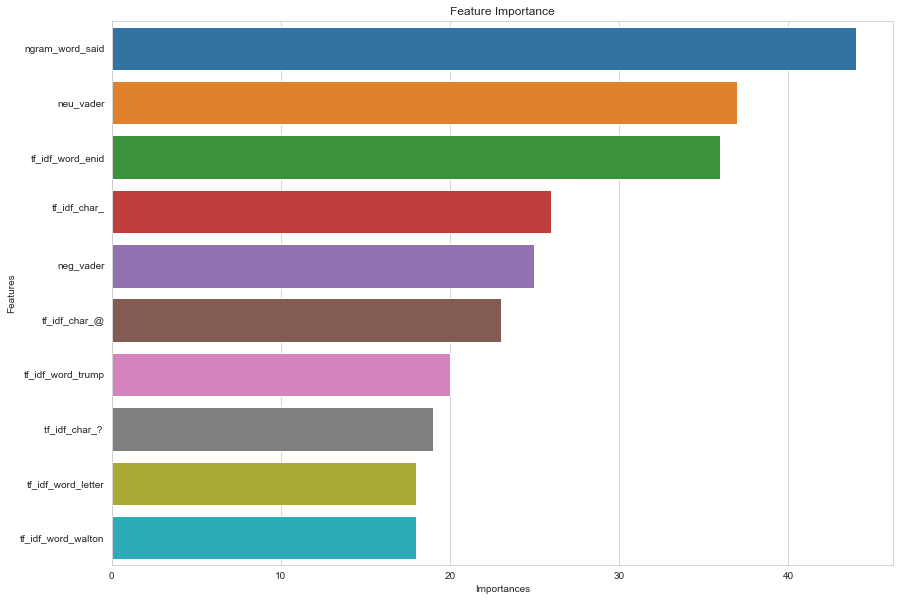

In [11]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)